<a href="https://colab.research.google.com/github/g-kitiashvili/ML-Assignment4/blob/main/Optimizer_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 09: Optimizer Comparison
## Objective: Compare SGD, Adam, and RMSprop optimizers on facial expression recognition

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
import copy
warnings.filterwarnings('ignore')

In [4]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

 86% 246M/285M [00:01<00:00, 132MB/s] 
100% 285M/285M [00:03<00:00, 82.8MB/s]
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv


In [7]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

icml_df = pd.read_csv('icml_face_data.csv')

# Split ICML data based on 'Usage'
icml_train = icml_df[icml_df[' Usage'] == 'Training']
icml_test = icml_df[icml_df[' Usage'].isin(['PublicTest', 'Other'])]

# Drop the 'Usage' column (not needed after splitting)
icml_train = icml_train.drop(columns=[' Usage'])
icml_test = icml_test.drop(columns=[' Usage'])

# Merge datasets
train_df = pd.concat([train_df, icml_train], ignore_index=True)
test_df = pd.concat([test_df, icml_test], ignore_index=True)

# **Added data type check and filtering**
print("\nChecking 'pixels' column data types...")
initial_train_rows = len(train_df)
initial_test_rows = len(test_df)

train_df = train_df[train_df['pixels'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['pixels'].apply(lambda x: isinstance(x, str))]

print(f"Removed {initial_train_rows - len(train_df)} rows from training set due to non-string 'pixels'.")
print(f"Removed {initial_test_rows - len(test_df)} rows from test set due to non-string 'pixels'.")

# Shuffle the merged datasets (optional but recommended)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output shapes and emotion distribution
print("\nMerged Train shape (after filtering):", train_df.shape)
print("Merged Test shape (after filtering):", test_df.shape)

print("\nEmotion distribution in merged train set:")
print(train_df['emotion'].value_counts().sort_index())

print("\nEmotion distribution in merged test set:")
print(test_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Checking 'pixels' column data types...
Removed 28709 rows from training set due to non-string 'pixels'.
Removed 3589 rows from test set due to non-string 'pixels'.

Merged Train shape (after filtering): (28709, 3)
Merged Test shape (after filtering): (7178, 3)

Emotion distribution in merged train set:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Emotion distribution in merged test set:
Series([], Name: count, dtype: int64)


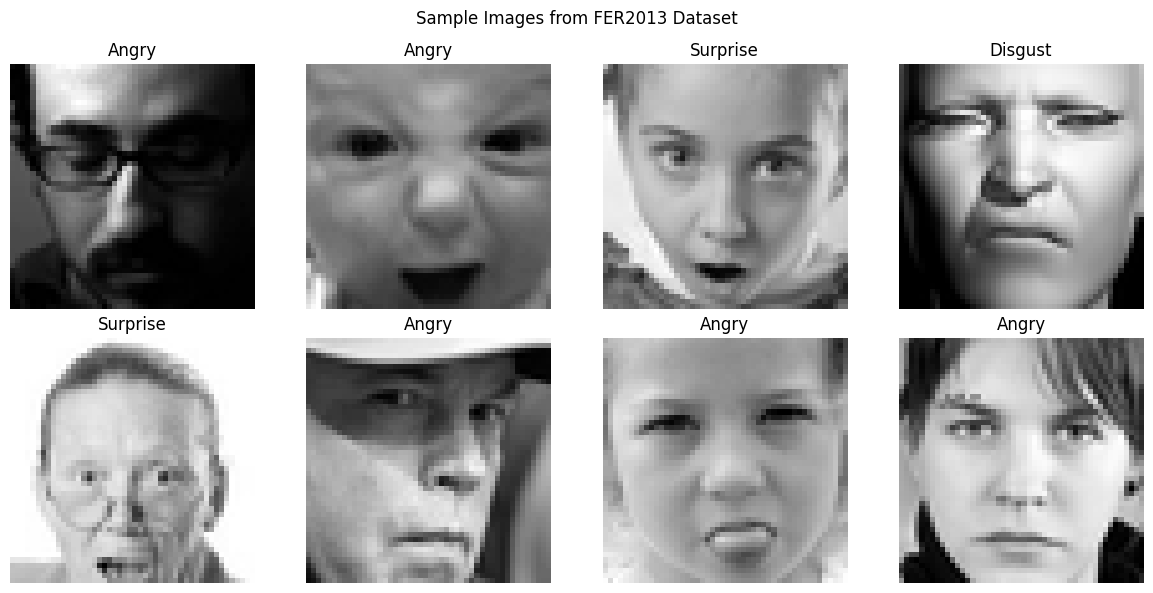

In [8]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
plt.show()

In [9]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.float32)
        pixels = pixels / 255.0  # Normalize to [0, 1]

        # For CNN, reshape to (1, 48, 48) - single channel
        pixels = pixels.reshape(1, 48, 48)

        return torch.tensor(pixels), torch.tensor(emotion, dtype=torch.long)

In [10]:
# Create datasets
full_dataset = FERDataset(train_df)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

Train size: 22967
Validation size: 5742


In [11]:
# CNN Model for Optimizer Comparison
class OptimizerTestCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(OptimizerTestCNN, self).__init__()

        # Conv Block 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Conv Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Activation and dropout
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Conv Block 1
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool1(x)

        # Conv Block 2
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.pool2(x)

        # Conv Block 3
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.pool3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x

In [12]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create a sample model to check parameter count
sample_model = OptimizerTestCNN().to(device)
print(f"Total parameters: {sample_model.total_params:,}")
del sample_model

Using device: cuda
Total parameters: 5,996,487


In [13]:
# Define optimizer configurations
optimizer_configs = {
    'SGD': {
        'optimizer_class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 1e-4},
        'scheduler': True,
        'color': 'red'
    },
    'Adam': {
        'optimizer_class': optim.Adam,
        'params': {'lr': 0.001, 'weight_decay': 1e-4},
        'scheduler': False,
        'color': 'blue'
    },
    'RMSprop': {
        'optimizer_class': optim.RMSprop,
        'params': {'lr': 0.001, 'weight_decay': 1e-4, 'momentum': 0.9},
        'scheduler': False,
        'color': 'green'
    }
}

print("Optimizer Configurations:")
print("=" * 50)
for name, config in optimizer_configs.items():
    print(f"{name}: {config['params']}")
print("=" * 50)

Optimizer Configurations:
SGD: {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001}
Adam: {'lr': 0.001, 'weight_decay': 0.0001}
RMSprop: {'lr': 0.001, 'weight_decay': 0.0001, 'momentum': 0.9}


In [14]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [15]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [16]:
# Train models with different optimizers
results = {}
num_epochs = 25

for optimizer_name, config in optimizer_configs.items():
    print(f"\n{'='*60}")
    print(f"Training with {optimizer_name} optimizer")
    print(f"{'='*60}")

    # Initialize W&B run for this optimizer
    wandb.init(
        project="fer-challenge",
        name=f"exp09-optimizer-{optimizer_name.lower()}",
        config={
            "architecture": "CNN for Optimizer Comparison",
            "dataset": "FER2013",
            "epochs": num_epochs,
            "batch_size": 64,
            "optimizer": optimizer_name,
            **config['params'],
            "num_classes": 7
        }
    )

    # Initialize model
    model = OptimizerTestCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    # Initialize optimizer
    optimizer = config['optimizer_class'](model.parameters(), **config['params'])

    # Initialize scheduler for SGD
    scheduler = None
    if config['scheduler']:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Track metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    learning_rates = []
    best_val_acc = 0

    # Log model to W&B
    wandb.watch(model, log='all')

    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs} - {optimizer_name}')
        print('-' * 40)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc, predictions, labels = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Step scheduler if applicable
        if scheduler is not None:
            scheduler.step()

        # Log to W&B
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'learning_rate': current_lr,
            'overfitting_gap': train_acc - val_acc
        })

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {current_lr:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{optimizer_name.lower()}_model.pth')

    # Store results
    results[optimizer_name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'learning_rates': learning_rates,
        'best_val_acc': best_val_acc,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1],
        'model': model,
        'color': config['color']
    }

    print(f"\n{optimizer_name} - Best Val Acc: {best_val_acc:.2f}%")

    # Finish W&B run
    wandb.finish()

    # api key 380014f2a984b49876832184c6bd2dcddb337047


Training with SGD optimizer


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/25 - SGD
----------------------------------------
Train Loss: 1.8281, Train Acc: 24.85%
Val Loss: 1.8109, Val Acc: 24.75%
Learning Rate: 0.010000

Epoch 2/25 - SGD
----------------------------------------
Train Loss: 1.8108, Train Acc: 25.23%
Val Loss: 1.8121, Val Acc: 24.75%
Learning Rate: 0.010000

Epoch 3/25 - SGD
----------------------------------------
Train Loss: 1.8008, Train Acc: 25.21%
Val Loss: 1.7830, Val Acc: 24.75%
Learning Rate: 0.010000

Epoch 4/25 - SGD
----------------------------------------
Train Loss: 1.7783, Train Acc: 25.87%
Val Loss: 1.7423, Val Acc: 28.68%
Learning Rate: 0.010000

Epoch 5/25 - SGD
----------------------------------------
Train Loss: 1.7144, Train Acc: 31.02%
Val Loss: 1.6533, Val Acc: 34.34%
Learning Rate: 0.010000

Epoch 6/25 - SGD
----------------------------------------
Train Loss: 1.6122, Train Acc: 37.10%
Val Loss: 1.5646, Val Acc: 39.10%
Learning Rate: 0.010000

Epoch 7/25 - SGD
----------------------------------------
Train Loss:

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,██████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
overfitting_gap,▂▂▂▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▇████
train_acc,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▅▆▆▆▇▇█████
train_loss,████▇▇▇▆▆▅▅▄▄▄▄▄▃▃▃▂▁▁▁▁▁
val_acc,▁▁▁▂▃▄▅▆▆▇▇▇▇▇███████████
val_loss,███▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▃▃▄▅▅▆▆
epoch,25
learning_rate,0.0001
overfitting_gap,33.41118
train_acc,88.0263



Training with Adam optimizer



Epoch 1/25 - Adam
----------------------------------------
Train Loss: 1.8203, Train Acc: 25.09%
Val Loss: 1.8211, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 2/25 - Adam
----------------------------------------
Train Loss: 1.8059, Train Acc: 25.26%
Val Loss: 1.7883, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 3/25 - Adam
----------------------------------------
Train Loss: 1.7362, Train Acc: 29.04%
Val Loss: 1.6606, Val Acc: 32.81%
Learning Rate: 0.001000

Epoch 4/25 - Adam
----------------------------------------
Train Loss: 1.5970, Train Acc: 37.54%
Val Loss: 1.5205, Val Acc: 40.68%
Learning Rate: 0.001000

Epoch 5/25 - Adam
----------------------------------------
Train Loss: 1.5016, Train Acc: 41.76%
Val Loss: 1.5081, Val Acc: 41.19%
Learning Rate: 0.001000

Epoch 6/25 - Adam
----------------------------------------
Train Loss: 1.4272, Train Acc: 44.75%
Val Loss: 1.4120, Val Acc: 44.85%
Learning Rate: 0.001000

Epoch 7/25 - Adam
----------------------------------------
Trai

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
overfitting_gap,▂▂▁▁▂▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇████
train_acc,▁▁▁▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇█████
train_loss,███▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
val_acc,▁▁▃▅▅▆▇▇██▇██████████████
val_loss,▅▄▄▃▂▂▁▁▁▁▁▁▂▂▂▃▄▄▅▅▆▇███
epoch,25
learning_rate,0.001
overfitting_gap,36.41967
train_acc,87.06405



Training with RMSprop optimizer



Epoch 1/25 - RMSprop
----------------------------------------
Train Loss: 258.9690, Train Acc: 23.42%
Val Loss: 1.8108, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 2/25 - RMSprop
----------------------------------------
Train Loss: 1.8131, Train Acc: 25.22%
Val Loss: 1.8106, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 3/25 - RMSprop
----------------------------------------
Train Loss: 5.9235, Train Acc: 25.24%
Val Loss: 1.8109, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 4/25 - RMSprop
----------------------------------------
Train Loss: 1.9860, Train Acc: 25.22%
Val Loss: 1.8120, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 5/25 - RMSprop
----------------------------------------
Train Loss: 2.6067, Train Acc: 25.12%
Val Loss: 1.8109, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 6/25 - RMSprop
----------------------------------------
Train Loss: 1.8922, Train Acc: 25.08%
Val Loss: 1.8111, Val Acc: 24.75%
Learning Rate: 0.001000

Epoch 7/25 - RMSprop
----------------------

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
overfitting_gap,▁████▇▇▇▇▇▇███▇▆▆▇▆▆▅▇▇▇▇
train_acc,▁████▇▇▇▇▇▇███▇▆▆▇▆▆▅▇▇▇▇
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▂▄▂▃▅▂▂▂▂▆▄▅▃▅▄▃█▁▆▃▁▃▃
epoch,25
learning_rate,0.001
overfitting_gap,0.24491
train_acc,24.99238


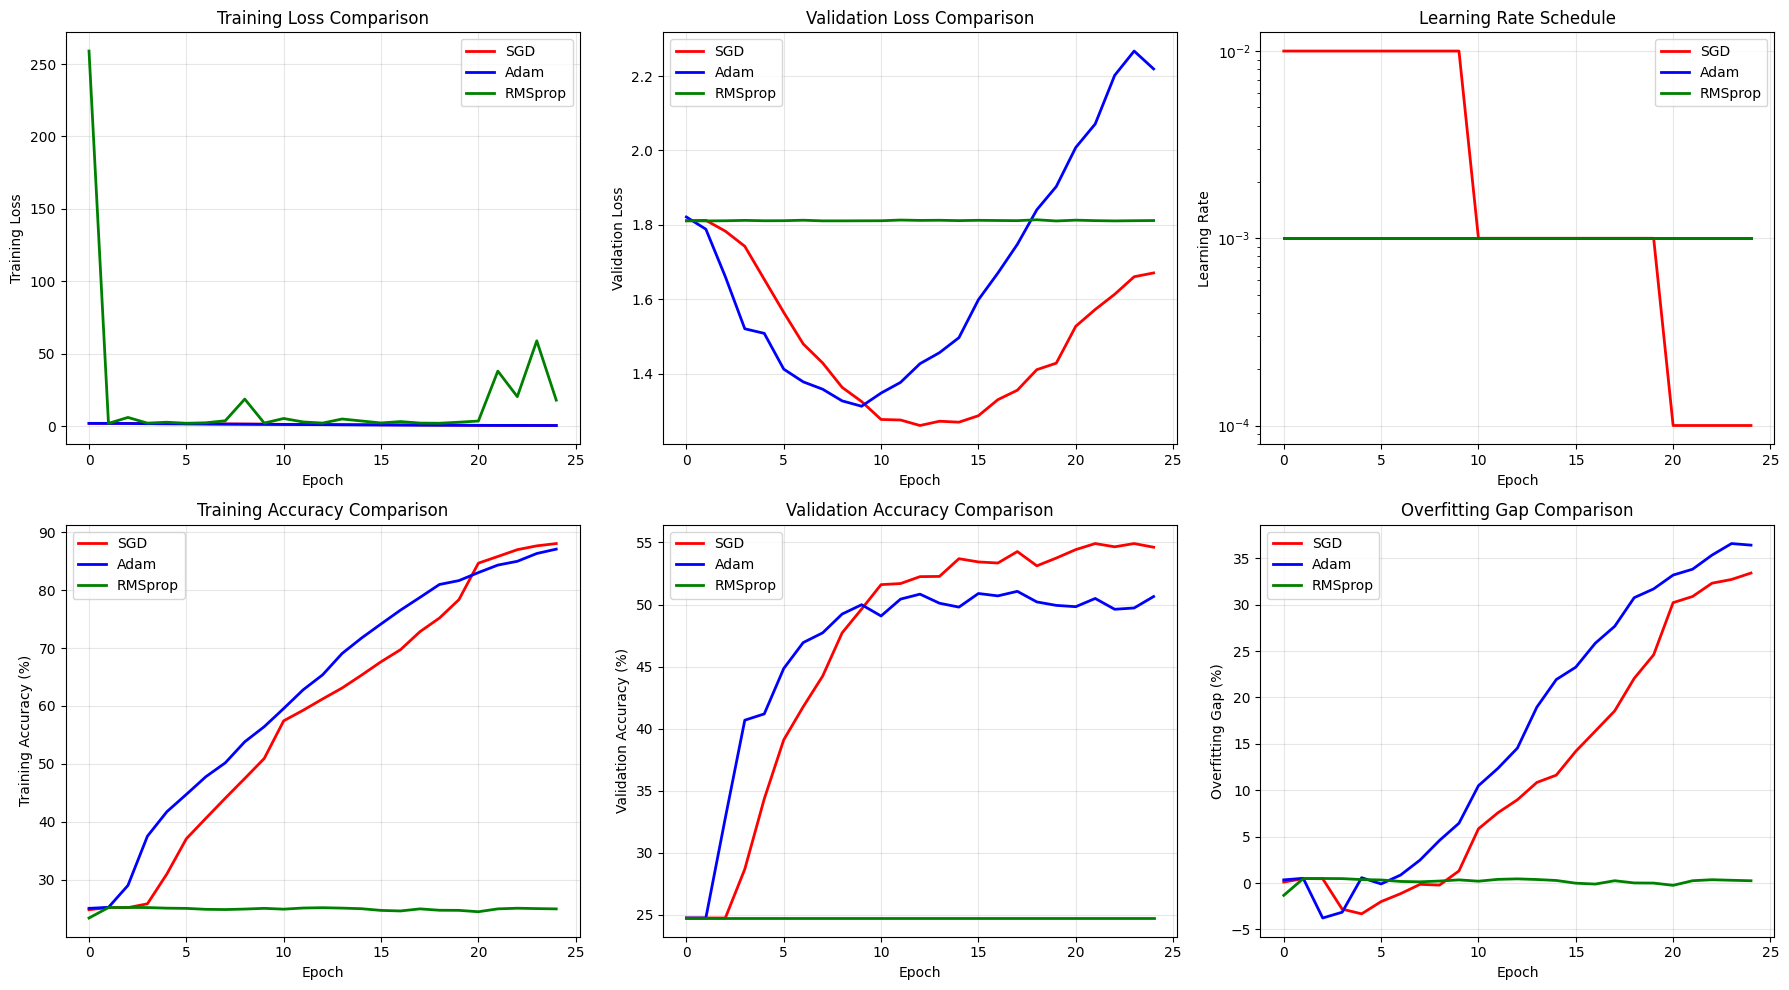

In [17]:
# Plot comparison of all optimizers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training Loss
for optimizer_name, data in results.items():
    axes[0, 0].plot(data['train_losses'], label=optimizer_name,
                   color=data['color'], linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
for optimizer_name, data in results.items():
    axes[0, 1].plot(data['val_losses'], label=optimizer_name,
                   color=data['color'], linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('Validation Loss Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
for optimizer_name, data in results.items():
    axes[1, 0].plot(data['train_accs'], label=optimizer_name,
                   color=data['color'], linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Training Accuracy (%)')
axes[1, 0].set_title('Training Accuracy Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
for optimizer_name, data in results.items():
    axes[1, 1].plot(data['val_accs'], label=optimizer_name,
                   color=data['color'], linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy (%)')
axes[1, 1].set_title('Validation Accuracy Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Learning Rate Schedule
for optimizer_name, data in results.items():
    axes[0, 2].plot(data['learning_rates'], label=optimizer_name,
                   color=data['color'], linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_title('Learning Rate Schedule')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_yscale('log')

# Overfitting Gap
for optimizer_name, data in results.items():
    overfitting_gaps = [data['train_accs'][i] - data['val_accs'][i] for i in range(len(data['train_accs']))]
    axes[1, 2].plot(overfitting_gaps, label=optimizer_name,
                   color=data['color'], linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Overfitting Gap (%)')
axes[1, 2].set_title('Overfitting Gap Comparison')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


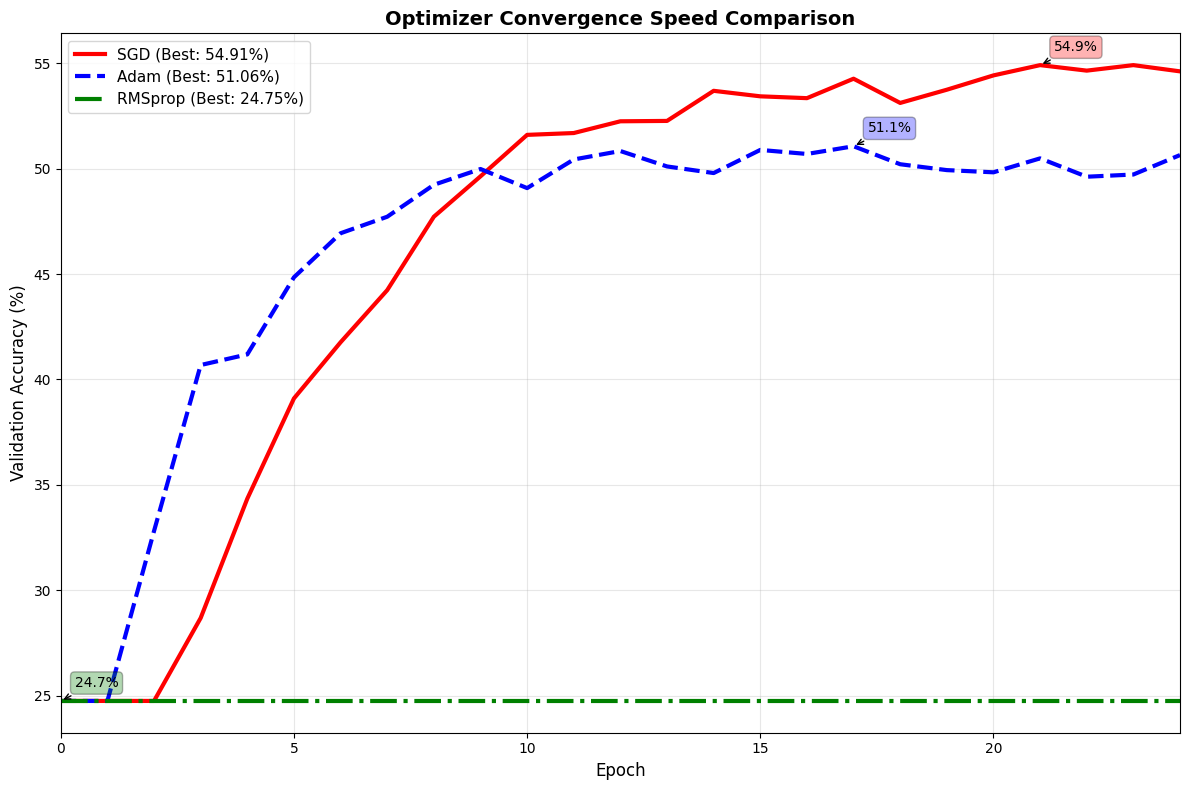

In [18]:
# Create convergence speed comparison
plt.figure(figsize=(12, 8))

# Plot validation accuracy with different line styles
line_styles = ['-', '--', '-.']
for i, (optimizer_name, data) in enumerate(results.items()):
    plt.plot(data['val_accs'], label=f'{optimizer_name} (Best: {data["best_val_acc"]:.2f}%)',
             color=data['color'], linewidth=3, linestyle=line_styles[i])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('Optimizer Convergence Speed Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, num_epochs-1)

# Add annotations for best performance
for optimizer_name, data in results.items():
    best_epoch = np.argmax(data['val_accs'])
    plt.annotate(f'{data["best_val_acc"]:.1f}%',
                xy=(best_epoch, data['best_val_acc']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=data['color'], alpha=0.3),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

In [19]:
# Performance summary table
summary_data = []
for optimizer_name, data in results.items():
    summary_data.append({
        'Optimizer': optimizer_name,
        'Best Val Acc (%)': f"{data['best_val_acc']:.2f}",
        'Final Train Acc (%)': f"{data['final_train_acc']:.2f}",
        'Final Val Acc (%)': f"{data['final_val_acc']:.2f}",
        'Final Overfitting Gap (%)': f"{data['final_train_acc'] - data['final_val_acc']:.2f}",
        'Epochs to Best': np.argmax(data['val_accs']) + 1,
        'Final Train Loss': f"{data['train_losses'][-1]:.4f}",
        'Final Val Loss': f"{data['val_losses'][-1]:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nOptimizer Performance Summary:")
print("=" * 120)
print(summary_df.to_string(index=False))
print("=" * 120)


Optimizer Performance Summary:
Optimizer Best Val Acc (%) Final Train Acc (%) Final Val Acc (%) Final Overfitting Gap (%)  Epochs to Best Final Train Loss Final Val Loss
      SGD            54.91               88.03             54.62                     33.41              22           0.3513         1.6707
     Adam            51.06               87.06             50.64                     36.42              18           0.3565         2.2192
  RMSprop            24.75               24.99             24.75                      0.24               1          17.8483         1.8115



Best performing optimizer: SGD
Best validation accuracy: 54.91%


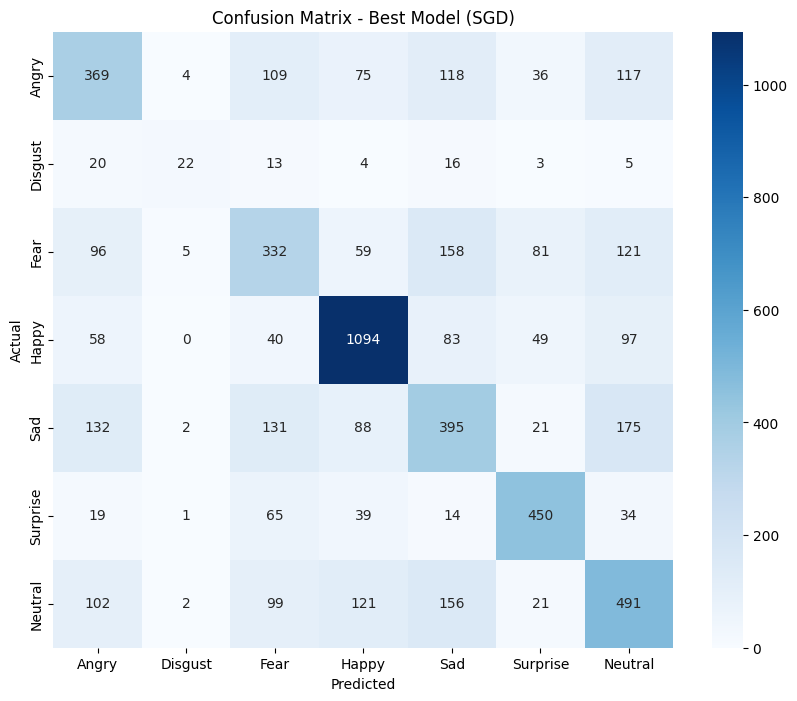

In [20]:
# Find the best performing optimizer
best_optimizer = max(results.keys(), key=lambda x: results[x]['best_val_acc'])
best_model = results[best_optimizer]['model']

print(f"\nBest performing optimizer: {best_optimizer}")
print(f"Best validation accuracy: {results[best_optimizer]['best_val_acc']:.2f}%")

# Load the best model and evaluate
best_model.load_state_dict(torch.load(f'best_{best_optimizer.lower()}_model.pth'))
_, _, final_predictions, final_labels = validate_epoch(best_model, val_loader, nn.CrossEntropyLoss(), device)

# Confusion matrix for best model
cm = confusion_matrix(final_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Best Model ({best_optimizer})')
plt.show()

In [21]:
# Classification report for best model
print(f"\nClassification Report - Best Model ({best_optimizer}):")
print("=" * 70)
report = classification_report(final_labels, final_predictions,
                             target_names=emotion_labels,
                             output_dict=True)
print(classification_report(final_labels, final_predictions, target_names=emotion_labels))


Classification Report - Best Model (SGD):
              precision    recall  f1-score   support

       Angry       0.46      0.45      0.45       828
     Disgust       0.61      0.27      0.37        83
        Fear       0.42      0.39      0.40       852
       Happy       0.74      0.77      0.75      1421
         Sad       0.42      0.42      0.42       944
    Surprise       0.68      0.72      0.70       622
     Neutral       0.47      0.49      0.48       992

    accuracy                           0.55      5742
   macro avg       0.54      0.50      0.51      5742
weighted avg       0.55      0.55      0.55      5742



In [22]:
# Analyze convergence characteristics
print("\nConvergence Analysis:")
print("=" * 60)

for optimizer_name, data in results.items():
    # Find when 90% of best performance was reached
    target_acc = 0.9 * data['best_val_acc']
    convergence_epoch = next((i for i, acc in enumerate(data['val_accs']) if acc >= target_acc), num_epochs)

    # Calculate stability (std dev of last 5 epochs)
    stability = np.std(data['val_accs'][-5:])

    # Calculate average improvement per epoch in first 10 epochs
    early_improvement = (data['val_accs'][9] - data['val_accs'][0]) / 10

    print(f"{optimizer_name}:")
    print(f"  - Convergence Speed (90% of best): Epoch {convergence_epoch + 1}")
    print(f"  - Stability (last 5 epochs std): {stability:.3f}")
    print(f"  - Early Improvement Rate: {early_improvement:.3f}% per epoch")
    print(f"  - Final Learning Rate: {data['learning_rates'][-1]:.6f}")
    print()


Convergence Analysis:
SGD:
  - Convergence Speed (90% of best): Epoch 10
  - Stability (last 5 epochs std): 0.187
  - Early Improvement Rate: 2.489% per epoch
  - Final Learning Rate: 0.000100

Adam:
  - Convergence Speed (90% of best): Epoch 7
  - Stability (last 5 epochs std): 0.422
  - Early Improvement Rate: 2.524% per epoch
  - Final Learning Rate: 0.001000

RMSprop:
  - Convergence Speed (90% of best): Epoch 1
  - Stability (last 5 epochs std): 0.000
  - Early Improvement Rate: 0.000% per epoch
  - Final Learning Rate: 0.001000



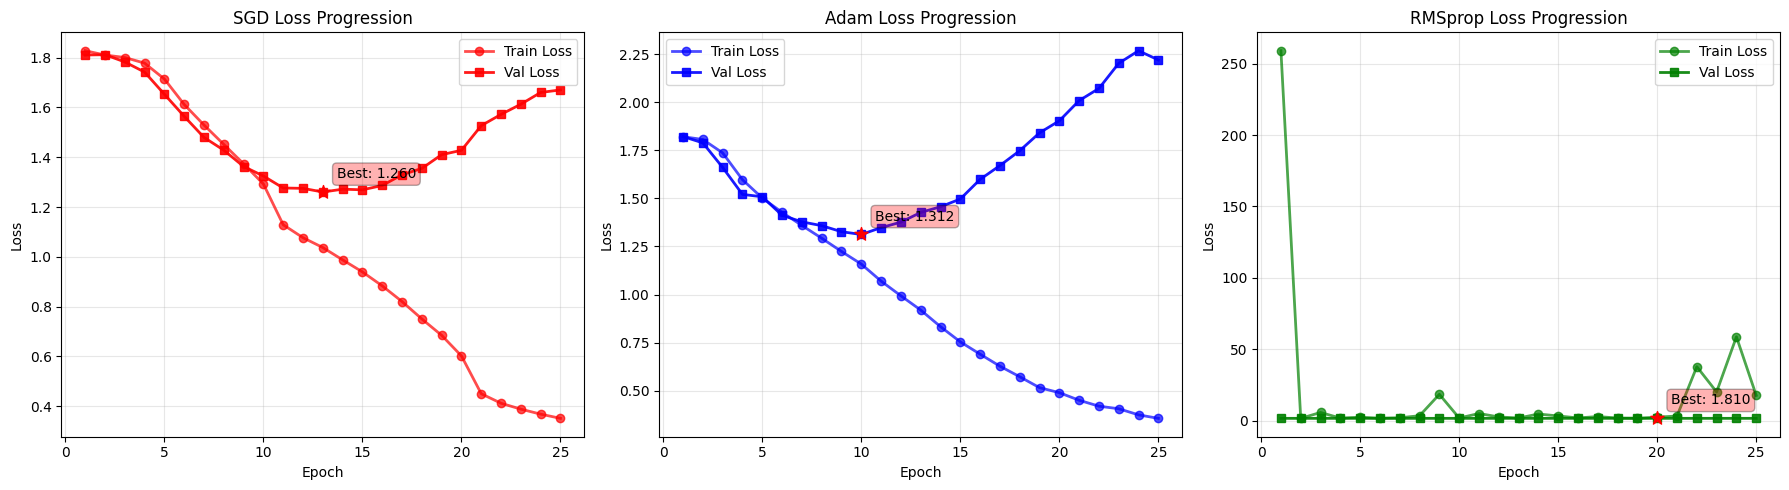

In [23]:
# Create detailed loss landscape comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (optimizer_name, data) in enumerate(results.items()):
    epochs = range(1, len(data['train_losses']) + 1)

    axes[i].plot(epochs, data['train_losses'], 'o-', label='Train Loss',
                color=data['color'], alpha=0.7, linewidth=2)
    axes[i].plot(epochs, data['val_losses'], 's-', label='Val Loss',
                color=data['color'], alpha=0.9, linewidth=2)

    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'{optimizer_name} Loss Progression')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

    # Add best validation point
    best_epoch = np.argmin(data['val_losses'])
    axes[i].scatter(best_epoch + 1, data['val_losses'][best_epoch],
                   color='red', s=100, zorder=5, marker='*')
    axes[i].annotate(f'Best: {data["val_losses"][best_epoch]:.3f}',
                    xy=(best_epoch + 1, data['val_losses'][best_epoch]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

plt.tight_layout()
plt.show()

In [24]:
# Save all models and create final summary
for optimizer_name in results.keys():
    torch.save(results[optimizer_name]['model'].state_dict(),
               f'final_{optimizer_name.lower()}_model.pth')

# Initialize final W&B run for comparison
wandb.init(
    project="fer-challenge",
    name="exp09-optimizer-comparison-summary",
    config={
        "experiment": "Optimizer Comparison",
        "optimizers": list(optimizer_configs.keys()),
        "dataset": "FER2013",
        "epochs": num_epochs,
        "architecture": "CNN for Optimizer Comparison"
    }
)

# Log comparison metrics
comparison_metrics = {}
for optimizer_name, data in results.items():
    comparison_metrics.update({
        f"{optimizer_name}_best_val_acc": data['best_val_acc'],
        f"{optimizer_name}_final_train_acc": data['final_train_acc'],
        f"{optimizer_name}_final_val_acc": data['final_val_acc'],
        f"{optimizer_name}_overfitting_gap": data['final_train_acc'] - data['final_val_acc'],
        f"{optimizer_name}_epochs_to_best": np.argmax(data['val_accs']) + 1
    })

wandb.log(comparison_metrics)

# Save models to W&B
for optimizer_name in results.keys():
    wandb.save(f'final_{optimizer_name.lower()}_model.pth')
    wandb.save(f'best_{optimizer_name.lower()}_model.pth')

In [28]:
# Final comprehensive analysis
print("\n" + "=" * 80)
print("EXPERIMENT SUMMARY: OPTIMIZER COMPARISON")
print("=" * 80)

print(f"\nModel Architecture:")
print(f"  - 3 Convolutional Blocks")
print(f"  - Conv channels: [64, 128, 256]")
print(f"  - FC layers: [512, 256, 7]")
# Get total parameters from one of the models stored in results
# Assuming all models have the same architecture and hence same parameter count
if results:
    # Pick any optimizer's model (e.g., the first one in results)
    any_optimizer_name = list(results.keys())[0]
    total_params = results[any_optimizer_name]['model'].total_params
    print(f"  - Total Parameters: {total_params:,}")
else:
    print("  - Total Parameters: N/A (No results found)")
print(f"  - Dropout: 0.3")

print(f"\nOptimizer Configurations:")
for name, config in optimizer_configs.items():
    print(f"  - {name}: {config['params']}")

print(f"\nPerformance Rankings (by Best Validation Accuracy):")
sorted_optimizers = sorted(results.items(), key=lambda x: x[1]['best_val_acc'], reverse=True)
for rank, (optimizer_name, data) in enumerate(sorted_optimizers, 1):
    print(f"  {rank}. {optimizer_name}: {data['best_val_acc']:.2f}% (Epoch {np.argmax(data['val_accs']) + 1})")

print(f"\nKey Observations:")
if sorted_optimizers:
    best_opt = sorted_optimizers[0][0]
    worst_opt = sorted_optimizers[-1][0]
    performance_gap = results[best_opt]['best_val_acc'] - results[worst_opt]['best_val_acc']

    print(f"  - Best performing optimizer: {best_opt}")
    print(f"  - Performance gap between best and worst: {performance_gap:.2f}%")
    # Ensure there are enough data points for std deviation calculation
    if all(len(data['val_accs']) >= 5 for data in results.values()):
         print(f"  - Most stable training: {min(results.keys(), key=lambda x: np.std(results[x]['val_accs'][-5:]))}")
    else:
         print("  - Stability (last 5 epochs std): Not enough data points for comparison")

    # SGD specific analysis
    if 'SGD' in results:
        sgd_data = results['SGD']
        lr_reduction_epochs = [i for i in range(1, len(sgd_data['learning_rates']))
                              if sgd_data['learning_rates'][i] < sgd_data['learning_rates'][i-1]]
        print(f"  - SGD learning rate reductions at epochs: {[e+1 for e in lr_reduction_epochs]}")

    print(f"\nConvergence Speed Analysis:")
    for optimizer_name, data in results.items():
        target_acc = 0.9 * data['best_val_acc']
        convergence_epoch = next((i for i, acc in enumerate(data['val_accs']) if acc >= target_acc), num_epochs)
        print(f"  - {optimizer_name}: Reached 90% of best performance at epoch {convergence_epoch + 1}")

    print(f"\nRecommendations:")
    if best_opt == 'Adam':
        print(f"  - Adam showed best overall performance with adaptive learning rates")
    elif best_opt == 'SGD':
        print(f"  - SGD with momentum and scheduling achieved best performance")
    elif best_opt == 'RMSprop':
        print(f"  - RMSprop provided best adaptive optimization for this task")

    print(f"  - Consider the trade-off between convergence speed and final performance")
    print(f"  - Hyperparameter tuning could further improve results for each optimizer")
else:
    print("\nNo results available to generate a summary.")


wandb.finish()


EXPERIMENT SUMMARY: OPTIMIZER COMPARISON

Model Architecture:
  - 3 Convolutional Blocks
  - Conv channels: [64, 128, 256]
  - FC layers: [512, 256, 7]
  - Total Parameters: 5,996,487
  - Dropout: 0.3

Optimizer Configurations:
  - SGD: {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001}
  - Adam: {'lr': 0.001, 'weight_decay': 0.0001}
  - RMSprop: {'lr': 0.001, 'weight_decay': 0.0001, 'momentum': 0.9}

Performance Rankings (by Best Validation Accuracy):
  1. SGD: 54.91% (Epoch 22)
  2. Adam: 51.06% (Epoch 18)
  3. RMSprop: 24.75% (Epoch 1)

Key Observations:
  - Best performing optimizer: SGD
  - Performance gap between best and worst: 30.16%
  - Most stable training: RMSprop
  - SGD learning rate reductions at epochs: [11, 21]

Convergence Speed Analysis:
  - SGD: Reached 90% of best performance at epoch 10
  - Adam: Reached 90% of best performance at epoch 7
  - RMSprop: Reached 90% of best performance at epoch 1

Recommendations:
  - SGD with momentum and scheduling achieved best

Adam_best_val_acc,▁
Adam_epochs_to_best,▁
Adam_final_train_acc,▁
Adam_final_val_acc,▁
Adam_overfitting_gap,▁
RMSprop_best_val_acc,▁
RMSprop_epochs_to_best,▁
RMSprop_final_train_acc,▁
RMSprop_final_val_acc,▁
RMSprop_overfitting_gap,▁
SGD_best_val_acc,▁
